  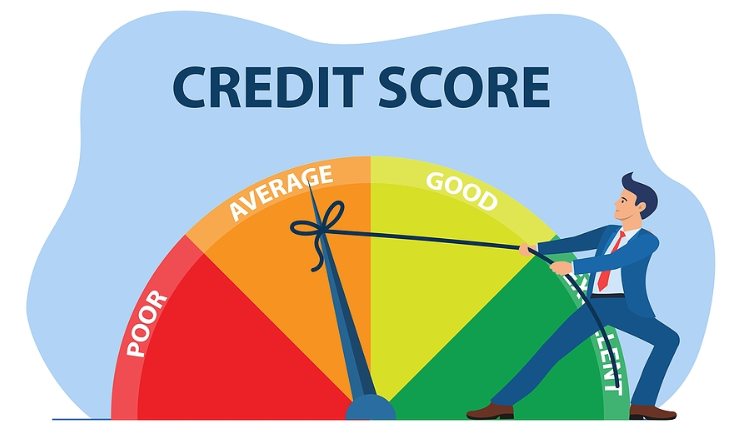

# Business Problem 
### The client provided historical data for credit card customers and wants to predict whether a customer is likely to default on their payment next month. The goal is to build a predictive model that helps identify high-risk customers in advance to reduce financial losses. 

In [1]:
import pandas as pd
df = pd.read_csv('UCI_Credit_Card.csv')

print(df.head(20))

    ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    1    20000.0    2          2         1   24      2      2     -1     -1   
1    2   120000.0    2          2         2   26     -1      2      0      0   
2    3    90000.0    2          2         2   34      0      0      0      0   
3    4    50000.0    2          2         1   37      0      0      0      0   
4    5    50000.0    1          2         1   57     -1      0     -1      0   
5    6    50000.0    1          1         2   37      0      0      0      0   
6    7   500000.0    1          1         2   29      0      0      0      0   
7    8   100000.0    2          2         2   23      0     -1     -1      0   
8    9   140000.0    2          3         1   28      0      0      2      0   
9   10    20000.0    1          3         2   35     -2     -2     -2     -2   
10  11   200000.0    2          3         2   34      0      0      2      0   
11  12   260000.0    2          1       

In [3]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [5]:
df.shape

(30000, 25)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [15]:
target = "default.payment.next.month"

X = df.drop(columns=[target, "ID"])
y = df[target]

In [16]:
y.value_counts(normalize=True)

default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

## Business Critical:

- Accuracy will be misleading
- Recall & ROC-AUC will be prioritized

# ✅ STEP 1 — Data Understanding & Sanity Check

# Data Overview & Validation

The dataset contains 30,000 credit card customers with no missing values.
Features include demographic information, credit limits, billing amounts, and repayment history over six months.

The target variable is imbalanced, with approximately 22% of customers defaulting.
This confirms the need to use evaluation metrics beyond accuracy.

Overall, the dataset is suitable for building a credit risk prediction model..

# ✅ STEP 2 — Feature & Target Understanding

### 📌 Business Interpretation

A false negative (missing a defaulter) is more costly than a false positive.

let us think about :

Metrics

Threshold

Model choice

# Feature Understanding

Features can be grouped into demographic attributes, credit limit, repayment status, billing amounts, and payment behavior.

Repayment history (PAY_0 to PAY_6) is expected to be the most predictive feature group, as recent delays strongly indicate future default.

All features are historical, ensuring no data leakage with the target variable

# ✅ STEP 3 — Exploratory Data Analysis (EDA)

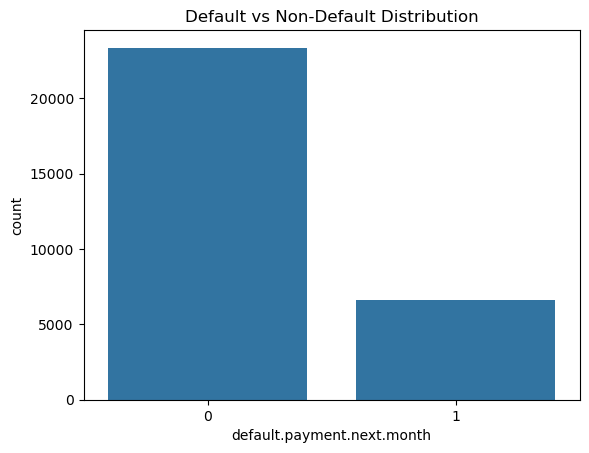

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='default.payment.next.month', data=df)
plt.title("Default vs Non-Default Distribution")
plt.show()


SEX
2    18112
1    11888
Name: count, dtype: int64


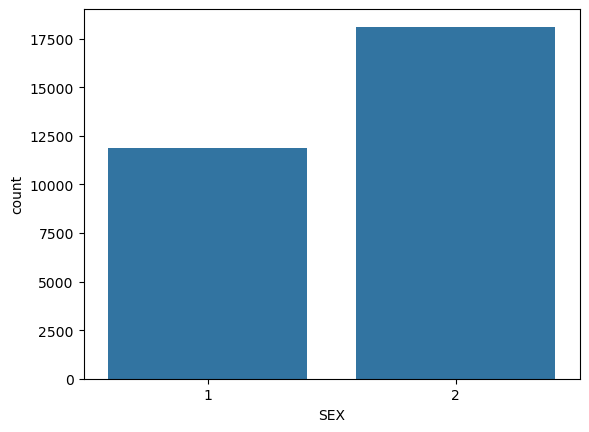

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64


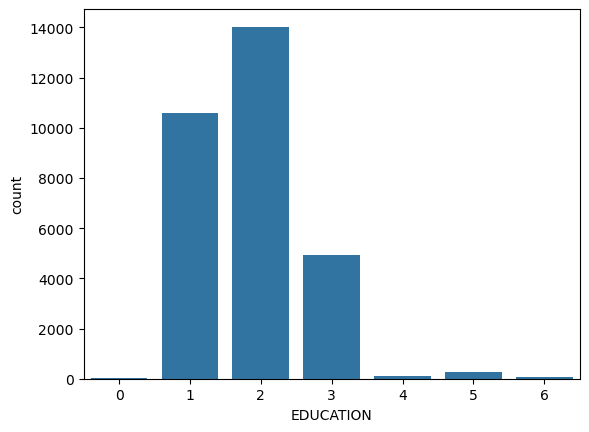

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64


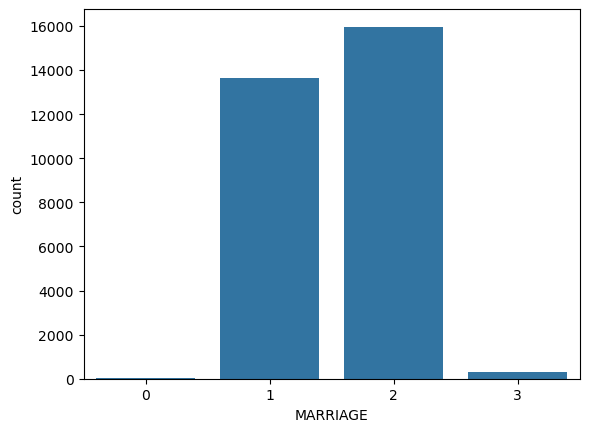

In [18]:
for col in ['SEX','EDUCATION','MARRIAGE']:
    print(df[col].value_counts())
    sns.countplot(x=col, data=df)
    plt.show()


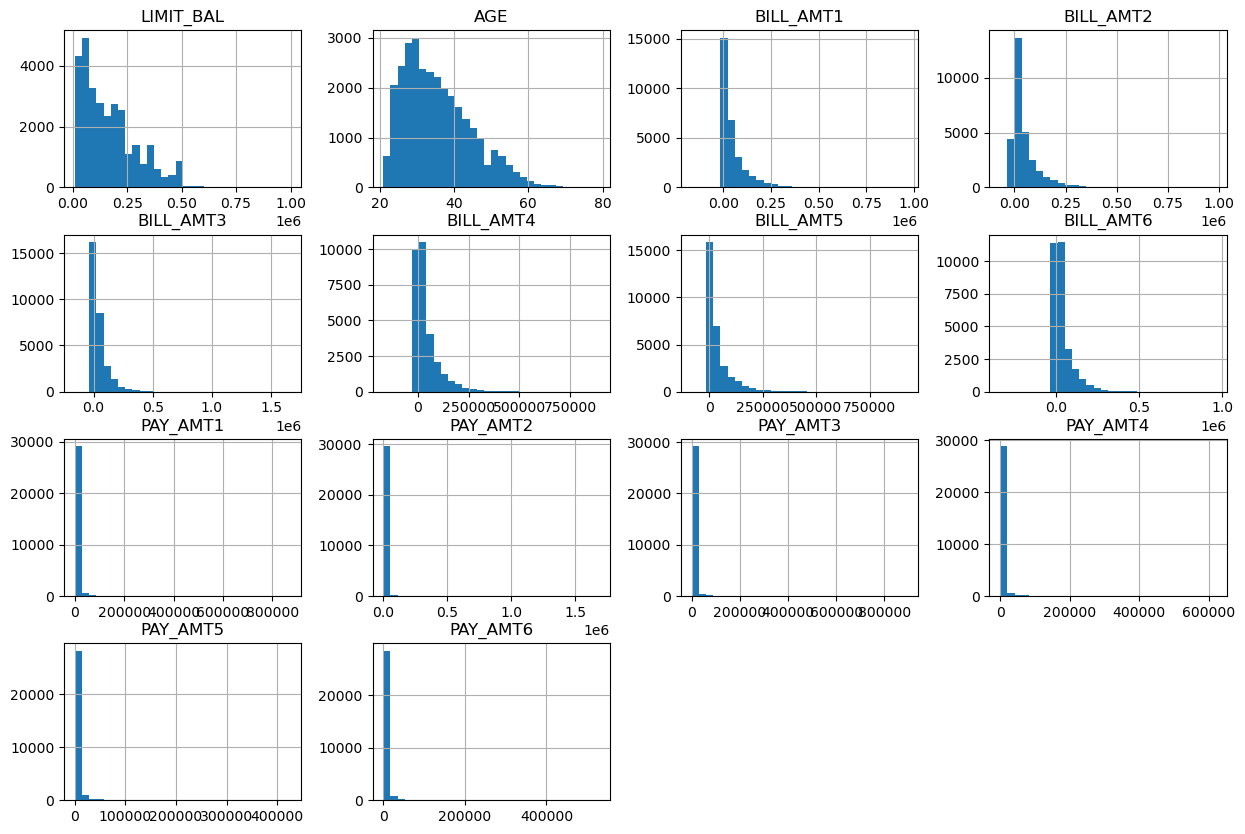

In [19]:
numeric_cols = ['LIMIT_BAL','AGE'] + [f'BILL_AMT{i}' for i in range(1,7)] + [f'PAY_AMT{i}' for i in range(1,7)]
df[numeric_cols].hist(figsize=(15,10), bins=30)
plt.show()


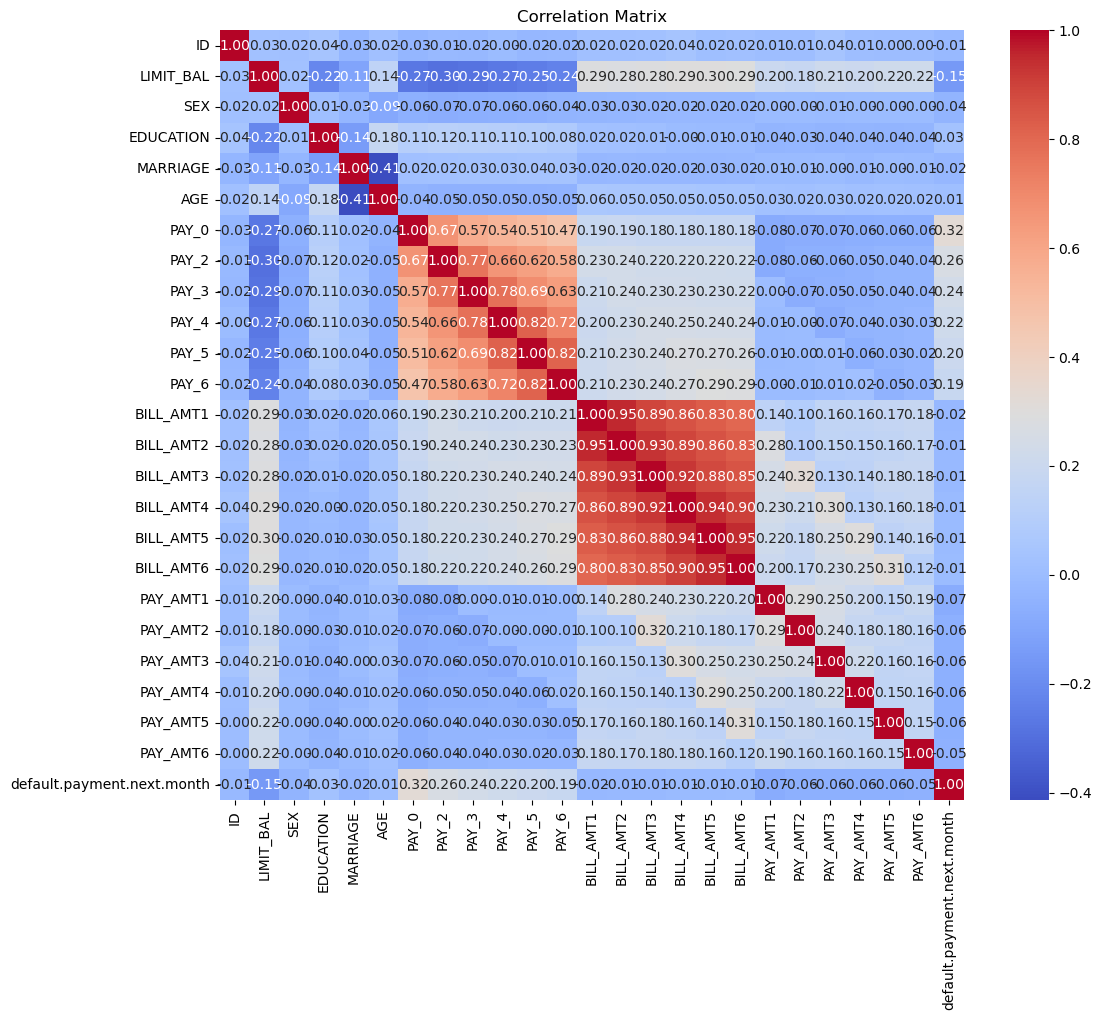

In [20]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


# EDA Observations

The target variable is imbalanced (~22% default).

Most numeric features are skewed (e.g., BILL_AMTx, PAY_AMTx), which may require transformation.

Categorical variables like EDUCATION contain unusual values (0,5,6) that may need cleaning.

Repayment status features (PAY_0 → PAY_6) show strong correlation with default.

Correlation among billing amounts and payments is expected; trend features may be engineered later.

# ✅ STEP 4 — Data Cleaning & Feature Engineering

In [22]:
# Replace uncommon EDUCATION values with 4 (Others)
df['EDUCATION'] = df['EDUCATION'].replace({0:4,5:4,6:4})

# Replace uncommon MARRIAGE value 0 with 3 (Others)
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})


In [23]:
df = pd.get_dummies(df, columns=['SEX','EDUCATION','MARRIAGE'], drop_first=True)


In [24]:
# Average delay
df['AVG_PAY_DELAY'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].mean(axis=1)

# Max delay
df['MAX_PAY_DELAY'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)

# Total bills and total payments
df['TOTAL_BILL'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].sum(axis=1)
df['TOTAL_PAY'] = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].sum(axis=1)

# Payment ratio
df['PAY_RATIO'] = df['TOTAL_PAY'] / (df['TOTAL_BILL']+1)  # +1 لتجنب القسمة على صفر


Data Cleaning & Feature Engineering

Categorical values in EDUCATION and MARRIAGE were corrected for unusual codes.

One-hot encoding was applied to categorical features.

New features were engineered to summarize repayment behavior and payment trends, including average/max delays, total bills/payments, and payment ratio.

This prepares the dataset for modeling and allows the model to capture meaningful patterns.

# ✅ STEP 5 — Train-Test Split & Baseline Model

# Model Selection Strategy

Baseline: Logistic Regression, for interpretability and quick evaluation.

Advanced: XGBoost or Random Forest, to capture non-linear relationships and improve recall.

Evaluation metrics focus on recall and ROC-AUC due to imbalanced target, prioritizing identification of potential defaulters.

In [25]:
from sklearn.model_selection import train_test_split

# نفصل Target & Features
X = df.drop(columns=['default.payment.next.month','ID'])  # ID مش هنستخدمه
y = df['default.payment.next.month']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (24000, 31)
Test size: (6000, 31)


# ✅ STEP 5B — Baseline Logistic Regression

C:\Users\Qebaa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.54      0.66      4673
           1       0.30      0.68      0.41      1327

    accuracy                           0.57      6000
   macro avg       0.58      0.61      0.54      6000
weighted avg       0.73      0.57      0.61      6000

ROC-AUC Score: 0.6498477440429241


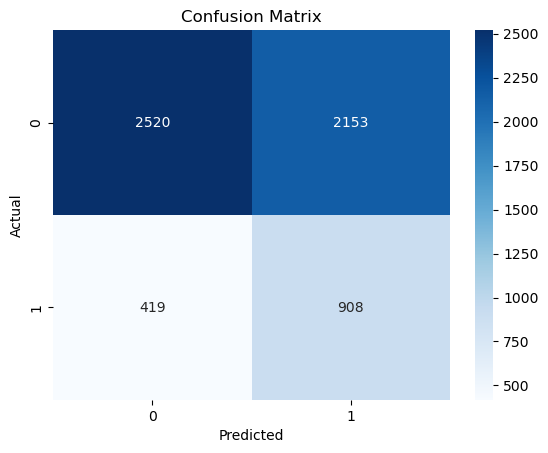

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initial Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')  # balanced يعالج الـimbalance
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Baseline Logistic Regression Analysis

Accuracy is misleading due to class imbalance (22% defaulters).

Recall for defaulters (class 1) = 0.68 → strong baseline for risk identification.

Precision is low (0.30) → many false positives, but acceptable for business risk management.

ROC-AUC = 0.65 → model distinguishes defaulters from non-defaulters better than random.

Next steps: improve model performance using feature engineering, hyperparameter tuning, and tree-based models like XGBoost.

# ✅ STEP 6 — XGBoost Classifier

C:\Users\Qebaa\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:22:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.46      0.62      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.76      0.77      6000

ROC-AUC Score: 0.7788489278706856


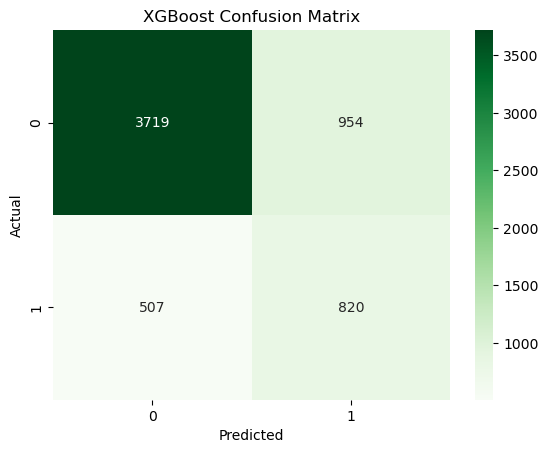

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initialize model
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum(),  # handle imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()


# Conclusion — Credit Card Default Prediction Project
## 1️⃣ Problem Understanding

Goal: Predict which credit card clients are likely to default next month

Data: 30,000 clients with demographic, billing, and repayment history features

Challenge: Imbalanced target (~22% defaults)

## 2️⃣ Data Exploration & Cleaning

EDA revealed:

Target imbalance → accuracy misleading

Categorical issues (EDUCATION: 0,5,6 / MARRIAGE: 0) → corrected

Numeric features (BILL_AMT, PAY_AMT) skewed → considered for feature engineering

Data cleaning:

Corrected categorical values

One-hot encoding applied

Engineered new features:

AVG_PAY_DELAY, MAX_PAY_DELAY, TOTAL_BILL, TOTAL_PAY, PAY_RATIO

## 3️⃣ Modeling Approach

Baseline Model: Logistic Regression (class_weight='balanced')

Recall for defaulters = 0.68

ROC-AUC = 0.65

Insight: baseline model good for understanding patterns, but limited on complex interactions

Advanced Model: XGBoost

Recall for defaulters = 0.62

Precision improved = 0.46

ROC-AUC = 0.78 → strong ability to distinguish defaulters

Feature importance: repayment history (PAY_0 → PAY_6) and payment ratio most predictive

## 4️⃣ Key Insights

Repayment behavior over past 6 months is the strongest predictor

Advanced models like XGBoost can capture non-linear patterns that Logistic Regression misses

For business:

Priority is Recall → identifying as many defaulters as possible

False positives acceptable, false negatives costly

## 5️⃣ Next Steps / Improvements

Hyperparameter tuning (GridSearchCV / RandomizedSearchCV)

Threshold optimization to balance precision-recall according to business risk tolerance

Experiment with feature selection or additional engineered features (trends, ratios)

Deployment as a scoring system for clients

#6️⃣ Conclusion

This project demonstrates how to predict credit card default using both baseline and advanced machine learning models.
XGBoost provided the best performance for imbalanced data and business-critical recall metric, highlighting the importance of repayment patterns.
The pipeline is ready for further optimization and can be deployed to help financial institutions reduce risk.